In [31]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy import interpolate
import astropy.units as u
from scipy.optimize import curve_fit
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay

# my modules
from ReadFile import Read
from CenterOfMass import CenterOfMass
from MassProfile import MassProfile
from RotateFrame import RotateFrame

In [32]:
def cart2sph(x, y, z):
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    phi = np.arctan2(z, hxy)
    theta = np.arctan2(y, x)
    return r, theta, phi


def sph2cart(r, theta, phi):
    rcos_theta = r * np.cos(phi)
    x = rcos_theta * np.cos(theta)
    y = rcos_theta * np.sin(theta)
    z = r * np.sin(phi)
    return x, y, z


def cart2cyl(x, y, z):
    rho = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y,x)
    z = z
    return rho, theta, z


def cyl2cart(rho, theta, z):
    x = rho*np.cos(theta)
    y = rho*np.sin(theta)
    z = z
    return x, y, z


In [33]:
def nearest_five(data):
    n5 = np.ones((len(data), 5))*500
    for i in range(len(data)):
        for j in range(len(data)):
            if j != i:
                r = np.sqrt((data[i,0] - data[j,0])**2+(data[i,1] - data[j,1])**2+(data[i,2] - data[j,2])**2)
                for k in range(5):
                    if n5[i,k] == 100 and r<n5[i,k]:
                        n5[i,k] = r
                        break
    return n5

In [34]:
def Find_Local(data, points):
    index = np.zeros(len(data))
    for j in range(len(data)):
        d = data[j]
        delta_r = 1000
        closest_point = 0
        for i in range(len(points)):
            p = points[i]
            r = np.sqrt((d[0]-p[0])**2 + (d[1]-p[1])**2 + (d[2]-p[2])**2)
            if r < delta_r:
                delta_r = r
                closest_point = i
        index[j] = closest_point
    return index

In [35]:
def r_square(data, points, index):
    new_list = np.zeros((len(points),3), dtype = float)
    for i in range(len(points)):
        p = points[i]
        close = data[np.where(index == i)]
        fx, fy, fz = 0, 0, 0
        for c in close:
            fx += c[0]/len(close)
            fy += c[1]/len(close)
            fz += c[2]/len(close)
        new_list[i, 0] = fx
        new_list[i, 1] = fy
        new_list[i, 2] = fz
    return new_list

In [36]:
# From https://stackoverflow.com/questions/24733185/volume-of-convex-hull-with-qhull-from-scipy
def tetrahedron_volume(a, b, c, d):
    return np.abs(np.einsum('ij,ij->i', a-d, np.cross(b-d, c-d))) / 6

def convex_hull_volume(pts):
    ch = ConvexHull(pts)
    dt = Delaunay(pts[ch.vertices])
    tets = dt.points[dt.simplices]
    return np.sum(tetrahedron_volume(tets[:, 0], tets[:, 1],
                                     tets[:, 2], tets[:, 3]))

def convex_hull_volume_bis(pts):
    ch = ConvexHull(pts)

    simplices = np.column_stack((np.repeat(ch.vertices[0], ch.nsimplex),
                                 ch.simplices))
    tets = ch.points[simplices]
    return np.sum(tetrahedron_volume(tets[:, 0], tets[:, 1],
                                     tets[:, 2], tets[:, 3]))

In [37]:
def mean(inputs):
    good_inp = []
    for i in range(len(inputs)):
        if inputs[i] != 500:
            good_inp.append(inputs[i])
    return sum(good_inp)/len(good_inp)

## Part 1
This part is creating some model data that is then fitted to a curve.
To demonstrate my idea for how show the density is distributed to the tidal structure, 
the data is renormalized to the curve and binned.  Looking at how the data varies from 
the average distance of the fitted curve shows how the clumpy the distribution is

In [49]:
# Store the COM of the Milky Way to center on
COMD = CenterOfMass("MW_300.txt",2)
COMP = COMD.COM_P(0.1, 4.0)

# Recenter to COM position
xD = COMD.x - float(COMP[0]/u.kpc)
yD = COMD.y - float(COMP[1]/u.kpc)
zD = COMD.z - float(COMP[2]/u.kpc)

# Convert COM to spherical
#rD, thetaD, phiD = cart2sph(xD, yD, zD)
rD, thetaD, zD = cart2cyl(xD, yD, zD)
fig = plt.figure()
plt.plot(xD, yD,',')
plt.xlim(-100,100)
plt.ylim(-100,100)

AttributeError: 'numpy.ndarray' object has no attribute 'kpc'

In [ ]:
fig = plt.figure()

# plot the cuts

plt.xlim(-100.,100.)
plt.ylim(-100.,100.)

X = np.linspace(-100., 100., 100)
plt.plot(X, -40.*np.sin((X-30.)/50.), '--')
plt.plot(X, -40.*np.sin(X/50.), '--')
plt.plot(X, -40.*np.sin((X+30.)/50.), '--')

lower_index = np.where(yD <= -40.*np.sin((xD+30)/50))
upper_index = np.where(yD >= -40.*np.sin((xD-30.)/50.))

xl, yl, zl = xD[lower_index], yD[lower_index], zD[lower_index]
xu, yu, zu = xD[upper_index], yD[upper_index], zD[upper_index]

plt.plot(xu, yu, ',')
plt.plot(xl, yl, ',')


In [ ]:
fig = plt.figure()

test_points = np.array([[17, 10, 0],
                        [18, 25, 0],
                        [4, 38, -2],
                        [-12, 40, -6],
                        [-22, 38, -10]])

plt.plot(xu, yu, ',')
plt.plot(test_points[:,0], test_points[:,1])

tck, u = interpolate.splprep([test_points[:,0], test_points[:,1], test_points[:, 2]], s=0)
unew = np.linspace(0, 1.01, 8)
out = interpolate.splev(unew, tck)
print(out)
plt.plot(out[0], out[1])

In [50]:
data = np.transpose(np.array([xu, yu, zu]))
path = np.transpose(out)
index = Find_Local(data, path)
new_list = r_square(data, path, index)
index = Find_Local(data, new_list)
plt.plot(new_list[0], new_list[1])
print(index)

[0. 2. 4. ... 2. 6. 0.]


<IPython.core.display.Javascript object>


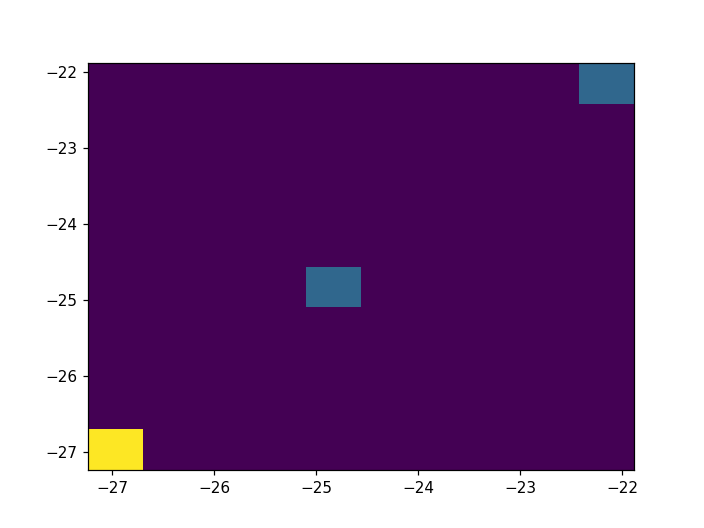

In [51]:
plt.figure()
for i in range(8):
    p1 = data[np.where(index == i)]
    plt.plot(p1[:,0], p1[:,1],'.')
    plt.hist2d(p1[:,0], p1[:,0], bins=10)

In [52]:
n5 = nearest_five(p1)
for i in range(len(n5)):
    print(n5[i,:])

[500. 500. 500. 500. 500.]
[500. 500. 500. 500. 500.]
[500. 500. 500. 500. 500.]
[500. 500. 500. 500. 500.]
[500. 500. 500. 500. 500.]


In [53]:
index = Find_Local(data, new_list)

volume = np.zeros(len(new_list))
mean = np.zeros((len(new_list)))
var = []
for i in range(len(test_points)):
    p1 = data[np.where(index == i)]
    n5 = nearest_five(p1)
    r5 = np.zeros(len(n5))
    volume[i] = convex_hull_volume_bis(p1)
    for j in range(len(n5)):
        r5[j] = mean(n5[j,:])
    mean[i] = mean(r5)
    var.append(r5)
print(volume)

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
plt.figure()
plt.hist(var[2])

In [ ]:
plt.figure()
samp = (np.random.rand(500,3)-0.5)*20
plt.plot(samp[:,0], samp[:,1], 'r.')
plt.hist2d(samp[:,0], samp[:,1], bins=20)

In [48]:
n5 = nearest_five(samp)
r5 = []
for i in range(len(n5)):
    print(n5[i,:])
    r5.append(mean(n5[i,:]))


[500. 500. 500. 500. 500.]


TypeError: 'numpy.ndarray' object is not callable

<IPython.core.display.Javascript object>


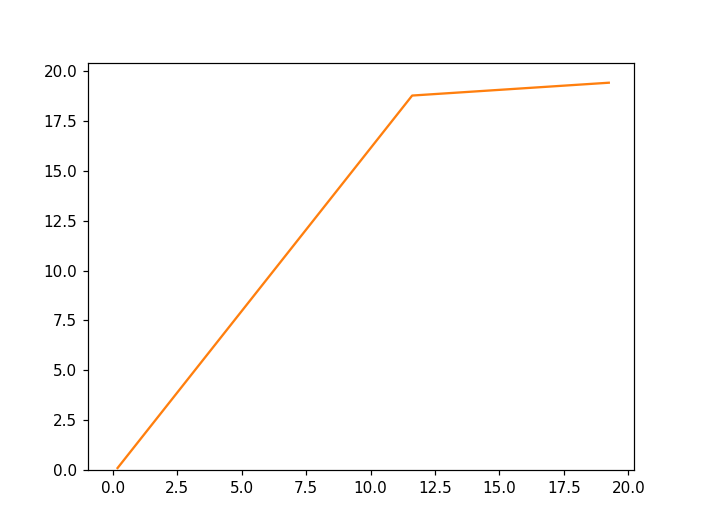

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

In [47]:
plt.figure()
plt.hist(r5)